# CS412 Machine Learning (Fall 2024)

**Group Members:** Kerim Taşkıran (29520), Eren Yamak (31283), İlke Öncü (28930)

# Import Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import gzip
import json
import re
from pprint import pprint
from sklearn.metrics import accuracy_score, classification_report
from pprint import pprint
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from collections import Counter

In [3]:
#@title Apply Turkish StopWords

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# PART 1: Influencer Category Classification


1.1.   Read Data

1.2.   Preprocess Data

1.3.   Prepare Model

1.4.   Predict Test Data

1.5.   Save outputs



**1.1. Read Data**

In [4]:
train_classification_df = pd.read_csv("/content/drive/MyDrive/CS412_Project_Round3/train-classification2.csv",)
train_classification_df = train_classification_df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})

# Unifying labels
train_classification_df["category"] = train_classification_df["category"].apply(str.lower)
username2_category = train_classification_df.set_index("user_id").to_dict()["category"]

In [5]:
# Label stats
train_classification_df.groupby("category").count()

,user_id
category,
art,243
entertainment,402
fashion,330
food,563
gaming,35
health and lifestyle,583
mom and children,164
sports,145
tech,390


from matplotlib import pyplot as plt
_df_0['user_id'].plot(kind='hist', bins=20, title='user_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['user_id'].plot(kind='line', figsize=(8, 4), title='user_id')
plt.gca().spines[['top', 'right']].set_visible(False)

In [6]:
#@title Process Meta-data

train_data_path = "/content/drive/MyDrive/CS412_Project_Round3/released_dataset/training-dataset.jsonl.gz"

username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()


with gzip.open(train_data_path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)

    profile = sample["profile"]
    username = profile["username"]
    if username in username2_category:
      username2posts_train[username] = sample["posts"]
      username2profile_train[username] = profile


    else:
      username2posts_test[username] = sample["posts"]
      username2profile_test[username] = profile


In [7]:
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

train_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,deparmedya,3170700063,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,None,1167,192,True,False,...,None,None,LOCAL,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,kafesfirin,266439571,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,None,11997,17,True,False,...,None,None,BRAND,False,False,https://instagram.fada1-13.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [8]:
test_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,beyazyakaliyiz,8634457436,Selam Beyaz Yakalı,Beyaz yakalıların dünyasına hoşgeldiniz 😀😀😀,Personal blog,None,1265,665,True,False,...,None,None,PERSONAL_BLOG,False,False,https://instagram.fist6-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,totalenergies_istasyonlari,7066643793,TotalEnergies İstasyonları,TotalEnergies İstasyonları resmi Instagram hes...,Energy Company,None,28025,4,True,False,...,None,None,ENERGY_COMPANY,False,False,https://instagram.fsaw2-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


**1.2. Preprocess Data**

The corpus will be created by aggregating all available post data into a single dataset. This unified corpus will then be implemented as input for the Tf-IDF vectorizer in scikit-learn, enabling precise feature extraction and analysis of the aggregated text data.

In [9]:
def preprocess_text(text: str):
    text = text.casefold()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

corpus = []
train_usernames = []

for username, posts in username2posts_train.items():
    train_usernames.append(username)

    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)
        if post_caption != "":
            cleaned_captions.append(post_caption)

    user_post_captions = "\n".join(cleaned_captions)
    corpus.append(user_post_captions)

vectorizer = TfidfVectorizer(stop_words=turkish_stopwords, max_features=5000)

vectorizer.fit(corpus)

x_post_train = vectorizer.transform(corpus)

y_train = [username2_category.get(uname, "NA") for uname in train_usernames]

test_usernames = []
test_corpus = []
for username, posts in username2posts_test.items():
    test_usernames.append(username)

    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)
        if post_caption != "":
            cleaned_captions.append(post_caption)

    user_post_captions = "\n".join(cleaned_captions)
    test_corpus.append(user_post_captions)

x_post_test = vectorizer.transform(test_corpus)

In [10]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['abdullah', 'abone', 'about', ..., 'şık', 'şıklık', 'şıklığı'],
      dtype=object)

In [79]:
df_tfidf = pd.DataFrame(x_post_train.toarray(), columns=feature_names)
df_tfidf.head(10)

,abdullah,abone,about,acele,acil,activities,acı,ad,ada,adam,...,şubemiz,şubesi,şölen,şöleni,şöyle,şükranla,şükür,şık,şıklık,şıklığı
0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.048561,0.0,0.0
1,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.042032,0.0,0.0,0.000000,0.0,0.0
3,0.04721,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.046679,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
5,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.014806,0.0,0.0
6,0.00000,0.0,0.0,0.0,0.010779,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
7,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
8,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.016554,0.0,0.0,0.000000,0.0,0.0
9,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [12]:
df_tfidf.shape

(2806, 5000)

In [13]:
#@title Train/Test Split

x_train, x_val, y_train, y_val = train_test_split(df_tfidf, y_train, test_size=0.2, stratify=y_train)

In [14]:
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [15]:
x_train.shape

(2244, 5000)

In [16]:
x_val.shape

(562, 5000)

**1.3. Preparing Model**

In [17]:
#@title Old Model (NN) used for Round 1 & 2
"""
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)

# Train the model
model.fit(x_train, y_train)
"""

'\nfrom sklearn.neural_network import MLPClassifier\nfrom sklearn.metrics import accuracy_score, classification_report\n\n# Initialize the model\nmodel = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)\n\n# Train the model\nmodel.fit(x_train, y_train)\n'

In [18]:
#@title New Model used for Round 3

log_reg = LogisticRegression(max_iter=1000)
param_grid_logreg = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga']}

# GridSearchCV
model = GridSearchCV(estimator=log_reg, param_grid=param_grid_logreg, cv=5, n_jobs=-1)
model.fit(x_train, y_train)

print("Best parameters for Logistic Regression:", model.best_params_)

# Training accuracy
y_train_pred_logreg = model.best_estimator_.predict(x_train)
train_accuracy_logreg = accuracy_score(y_train, y_train_pred_logreg)
print(f"Training accuracy (Logistic Regression): {train_accuracy_logreg:.4f}")

# Validation accuracy
y_val_pred_logreg = model.best_estimator_.predict(x_val)
val_accuracy_logreg = accuracy_score(y_val, y_val_pred_logreg)
print(f"Validation accuracy (Logistic Regression): {val_accuracy_logreg:.4f}")

# Classification report
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_val, y_val_pred_logreg))

# Cross-validation
cv_scores_logreg = cross_val_score(model.best_estimator_, x_train, y_train, cv=5)
print("Cross-validation score (Logistic Regression):", cv_scores_logreg.mean())

Best parameters for Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Training accuracy (Logistic Regression): 0.9857
Validation accuracy (Logistic Regression): 0.6601

Classification Report (Logistic Regression):
                      precision    recall  f1-score   support

                 art       0.48      0.29      0.36        41
       entertainment       0.49      0.55      0.51        66
             fashion       0.65      0.59      0.62        61
                food       0.77      0.88      0.83       104
              gaming       0.00      0.00      0.00         3
health and lifestyle       0.59      0.72      0.65       103
    mom and children       0.65      0.37      0.47        30
              sports       0.88      0.58      0.70        24
                tech       0.72      0.79      0.75        71
              travel       0.77      0.68      0.72        59

            accuracy                           0.66       562
           macro avg       0.60     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation score (Logistic Regression): 0.642608574610245


In [19]:
#@title Train Data
y_train_pred = model.predict(x_train)

print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, zero_division=0))

Accuracy: 0.9857397504456328

Classification Report:
                      precision    recall  f1-score   support

                 art       1.00      0.98      0.99       162
       entertainment       1.00      0.97      0.98       265
             fashion       0.98      1.00      0.99       245
                food       0.98      1.00      0.99       413
              gaming       1.00      1.00      1.00        13
health and lifestyle       0.99      0.98      0.98       413
    mom and children       0.99      0.99      0.99       117
              sports       1.00      1.00      1.00        98
                tech       0.98      0.99      0.99       285
              travel       0.98      0.98      0.98       233

            accuracy                           0.99      2244
           macro avg       0.99      0.99      0.99      2244
        weighted avg       0.99      0.99      0.99      2244



In [20]:
#@title Validation Data
y_val_pred = model.predict(x_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, zero_division=0))

Accuracy: 0.6601423487544484

Classification Report:
                      precision    recall  f1-score   support

                 art       0.48      0.29      0.36        41
       entertainment       0.49      0.55      0.51        66
             fashion       0.65      0.59      0.62        61
                food       0.77      0.88      0.83       104
              gaming       0.00      0.00      0.00         3
health and lifestyle       0.59      0.72      0.65       103
    mom and children       0.65      0.37      0.47        30
              sports       0.88      0.58      0.70        24
                tech       0.72      0.79      0.75        71
              travel       0.77      0.68      0.72        59

            accuracy                           0.66       562
           macro avg       0.60      0.54      0.56       562
        weighted avg       0.66      0.66      0.65       562



**1.4. Predict Test Data**

In [21]:
#@title Test Data

test_data_path = "/content/drive/MyDrive/CS412_Project_Round3/released_dataset/test-classification-round3.dat"
!head -n 5 "$test_data_path"

print("*****")

test_unames = []
with open(test_data_path, "rt") as fh:
  for line in fh:
    test_unames.append(line.strip())

print(test_unames[:5])

livapastanesi
barisgross
tusasshop
etolyadigital
tugrulonur
*****
['livapastanesi', 'barisgross', 'tusasshop', 'etolyadigital', 'tugrulonur']


In [22]:
x_test = []

for uname in test_unames:
  try:
    index = test_usernames.index(uname)
    x_test.append(x_post_test[index].toarray()[0])
  except Exception as e:
    try:
      index = train_usernames.index(uname)
      x_test.append(x_post_train[index].toarray()[0])
    except Exception as e:
      print(uname)


In [23]:
df_test = pd.DataFrame(np.array(x_test), columns=feature_names)
df_test.head(2)

,abdullah,abone,about,acele,acil,activities,acı,ad,ada,adam,...,şubemiz,şubesi,şölen,şöleni,şöyle,şükranla,şükür,şık,şıklık,şıklığı
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.034613,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [24]:
test_pred = model.predict(df_test)

output = dict()
for index, uname in enumerate(test_unames):
  output[uname] = test_pred[index]

**1.5. Save Outputs**

In [25]:
def capitalize_category(category):
    return ' '.join([word.capitalize() if word.lower() != 'and' else word.lower() for word in category.split()])

test_pred = model.predict(df_test)

output = dict()
for index, uname in enumerate(test_unames):
    output[uname] = capitalize_category(test_pred[index])

with open("prediction-classification-round3.json", "w") as of:
    json.dump(output, of, indent="\t")

In [26]:
y_test = [username2_category.get(uname, "NA") for uname in test_unames]

valid_indices = [i for i, label in enumerate(y_test) if label != "NA"]
y_test = [y_test[i] for i in valid_indices]
test_pred = [test_pred[i] for i in valid_indices]

print("***** Test Data Accuracy *****")
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Accuracy: {test_accuracy * 100:.2f}%")

# Classification report for detailed performance
print("\nClassification Report:")
print(classification_report(y_test, test_pred, zero_division=0))

***** Test Data Accuracy *****
Accuracy: 91.24%

Classification Report:
                      precision    recall  f1-score   support

                 art       0.92      0.85      0.88        27
       entertainment       0.90      0.82      0.86        45
             fashion       0.85      1.00      0.92        23
                food       0.97      0.94      0.95        31
              gaming       1.00      1.00      1.00         1
health and lifestyle       0.89      0.93      0.91        73
    mom and children       0.80      1.00      0.89         4
              sports       1.00      0.90      0.95        10
                tech       0.94      0.92      0.93        36
              travel       0.92      0.96      0.94        24

            accuracy                           0.91       274
           macro avg       0.92      0.93      0.92       274
        weighted avg       0.91      0.91      0.91       274



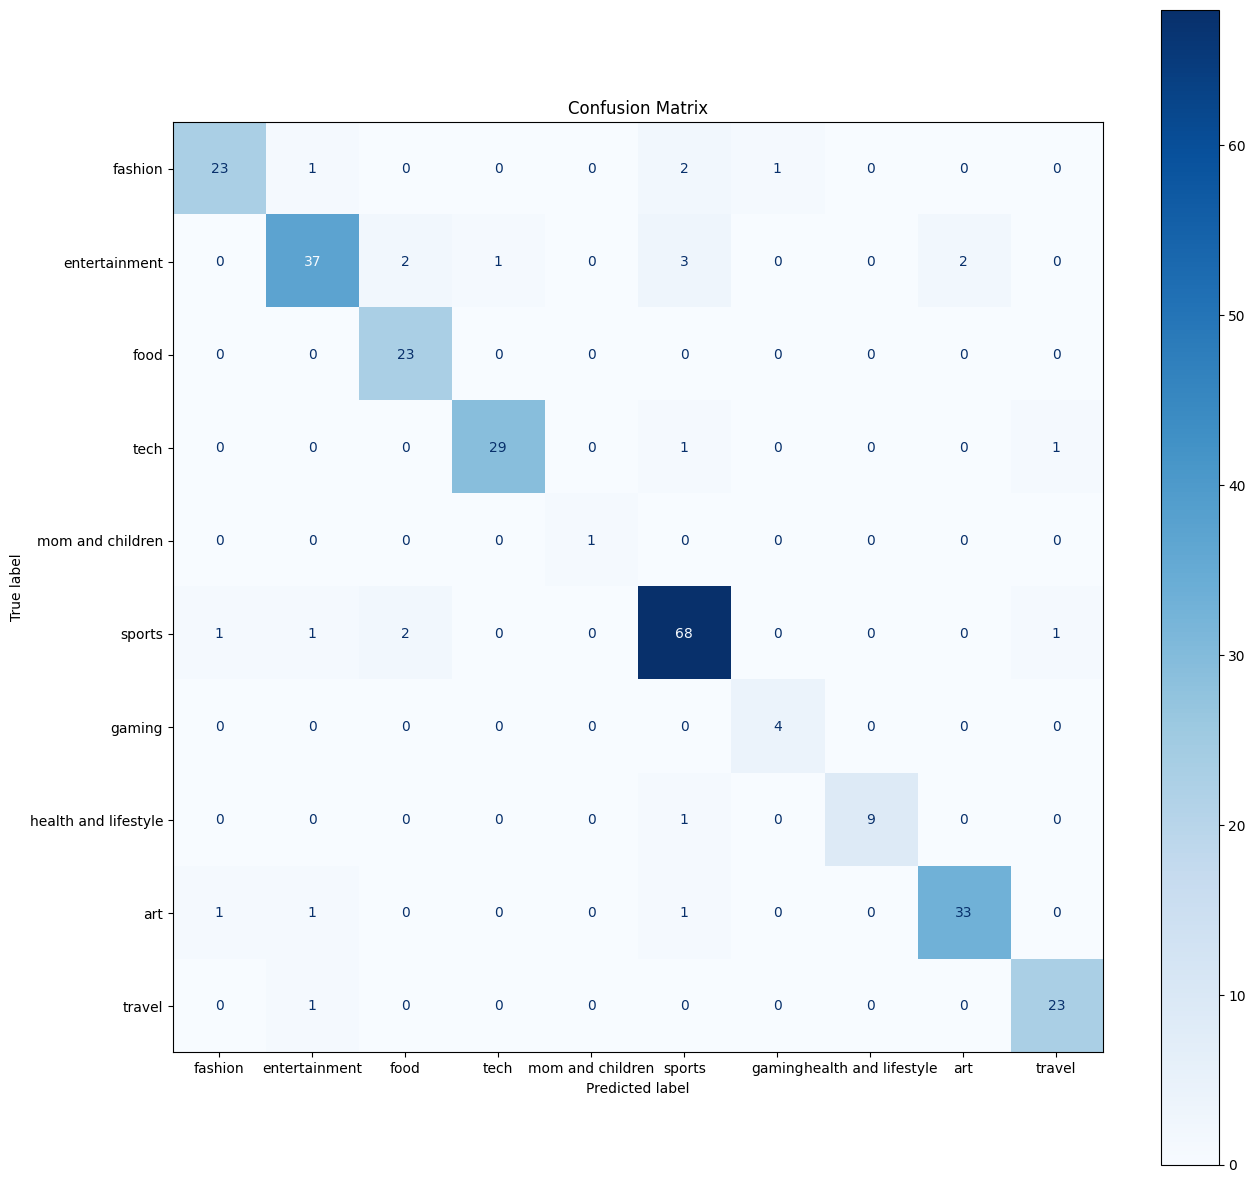

In [32]:
#Confusion matrix for Test Data
conf_matrix = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(set(y_test)))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

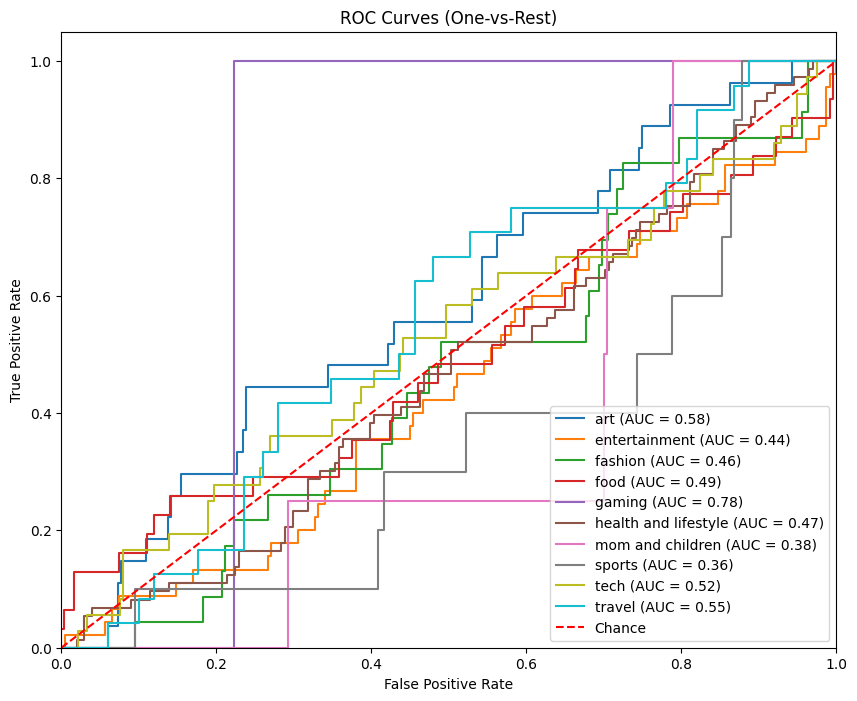

In [78]:
from sklearn.preprocessing import label_binarize

classes = list(model.classes_)

valid_indices = [i for i, label in enumerate(y_test) if label != "NA"]

y_test_labeled = [y_test[i] for i in valid_indices]
test_proba_labeled = test_proba[valid_indices, :]

y_test_binarized = label_binarize(y_test_labeled, classes=classes)

plt.figure(figsize=(10, 8))

for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], test_proba_labeled[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'r--', label='Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()

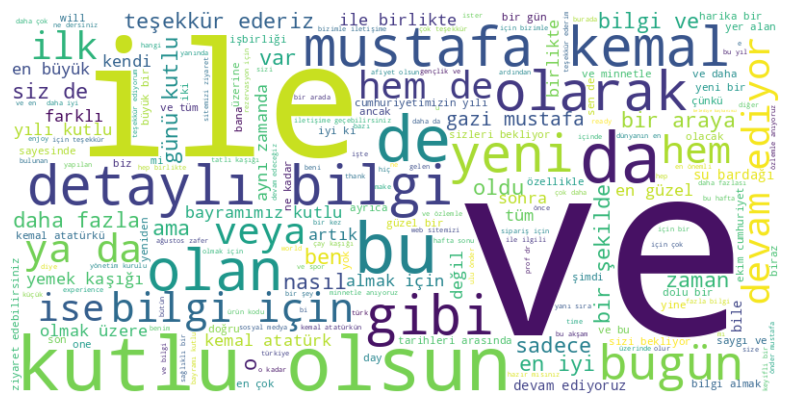

In [41]:
from wordcloud import WordCloud

all_text = " ".join(corpus)
wc = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


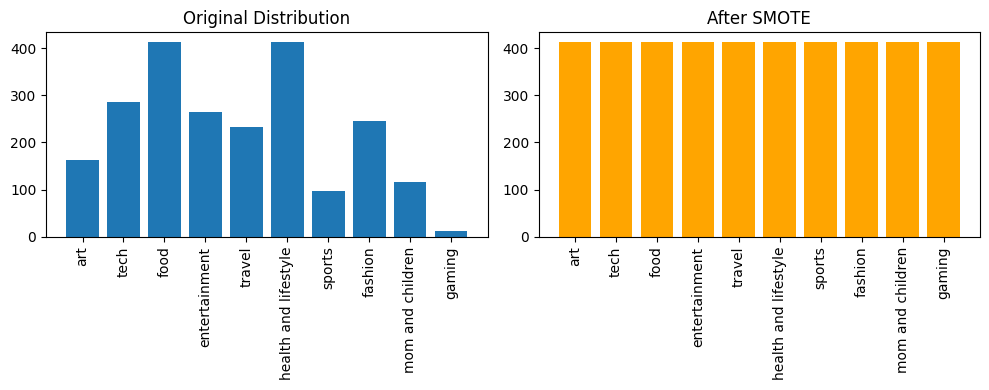

In [43]:
from collections import Counter

original_counts = Counter(y_train)
resampled_counts = Counter(y_train_resampled)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(original_counts.keys(), original_counts.values())
plt.title("Original Distribution")
plt.xticks(rotation=90)

plt.subplot(1,2,2)
plt.bar(resampled_counts.keys(), resampled_counts.values(), color='orange')
plt.title("After SMOTE")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


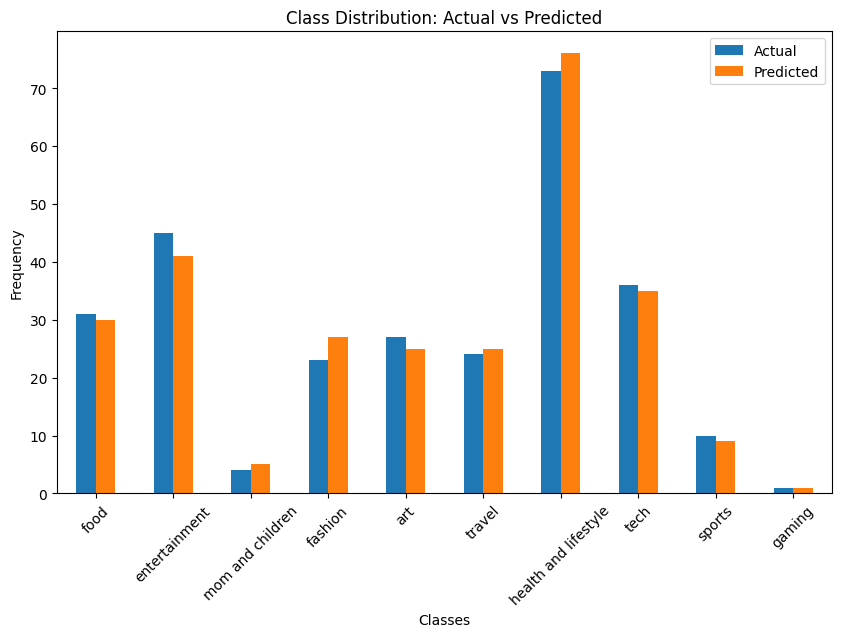

In [35]:
#Actual vs. Predicted Plot

actual_counts = Counter(y_test)
predicted_counts = Counter(test_pred)

freq_df = pd.DataFrame({'Actual': actual_counts, 'Predicted': predicted_counts}).fillna(0)

freq_df.plot(kind="bar", figsize=(10, 6))
plt.title("Class Distribution: Actual vs Predicted")
plt.ylabel("Frequency")
plt.xlabel("Classes")
plt.xticks(rotation=45)
plt.show()


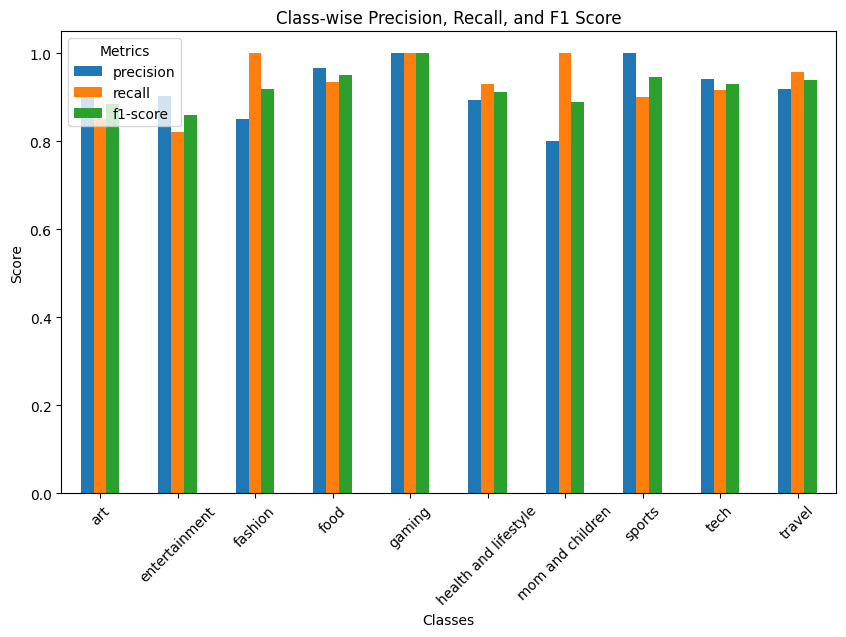

In [45]:
#Class-wise F1 scores

report = classification_report(y_test, test_pred, output_dict=True)

class_scores = pd.DataFrame(report).T.iloc[:-3, :3]

class_scores.plot(kind="bar", figsize=(10, 6))
plt.title("Class-wise Precision, Recall, and F1 Score")
plt.ylabel("Score")
plt.xlabel("Classes")
plt.xticks(rotation=45)
plt.legend(title="Metrics")
plt.show()

In [46]:
valid_test_labels = [uname for uname in test_unames if username2_category.get(uname, "NA") != "NA"]
print(f"Valid test samples with labels: {len(valid_test_labels)} / {len(test_unames)}")

Valid test samples with labels: 274 / 1000


In [47]:
train_categories = set(train_classification_df['category'].unique())
test_categories = set(username2_category.get(uname, "NA") for uname in test_unames)

print(f"Categories in Training Data: {train_categories}")
print(f"Categories in Test Data: {test_categories}")
print(f"Categories Missing in Training Data: {test_categories - train_categories}")


Categories in Training Data: {'fashion', 'entertainment', 'food', 'tech', 'mom and children', 'gaming', 'art', 'health and lifestyle', 'sports', 'travel'}
Categories in Test Data: {'fashion', 'entertainment', 'food', 'NA', 'tech', 'mom and children', 'sports', 'gaming', 'health and lifestyle', 'art', 'travel'}
Categories Missing in Training Data: {'NA'}


In [48]:
test_label_distribution = pd.Series(
    [username2_category.get(uname, "NA") for uname in test_unames]
).value_counts()

print("Test Data Label Distribution:")
print(test_label_distribution)

Test Data Label Distribution:
NA                      726
health and lifestyle     73
entertainment            45
tech                     36
food                     31
art                      27
travel                   24
fashion                  23
sports                   10
mom and children          4
gaming                    1
Name: count, dtype: int64


# PART 2: Like Count Prediction


In this approach, the average like_count of a user's previous posts is utilized as the predictive value for estimating the like_count of each individual post. This method assumes that a user's historical engagement patterns provide a reliable baseline for forecasting future post performance.

In [49]:
def predict_like_count(username, current_post=None):
  def get_avg_like_count(posts:list):
    total = 0.
    for post in posts:
      if current_post is not None and post["id"] == current_post["id"]:
        continue

      like_count = post.get("like_count", 0)
      if like_count is None:
        like_count = 0
      total += like_count

    if len(posts) == 0:
      return 0.

    return total / len(posts)

  if username in username2posts_train:
    return get_avg_like_count(username2posts_train[username])
  elif username in username2posts_test:
    return get_avg_like_count(username2posts_test[username])
  else:
    print(f"No data available for {username}")
    return -1

In [50]:
def log_mse_like_counts(y_true, y_pred):

  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # Log transformation: log(like_count + 1)
  log_y_true = np.log1p(y_true)
  log_y_pred = np.log1p(y_pred)

  squared_errors = (log_y_true - log_y_pred) ** 2

  return np.mean(squared_errors)

In [51]:
#@title Train Dataset evaluation via Log MSE

y_like_count_train_true = []
y_like_count_train_pred = []
for uname, posts in username2posts_train.items():
  for post in posts:
    pred_val = predict_like_count(uname, post)
    true_val = post.get("like_count", 0)
    if true_val is None:
      true_val = 0

    y_like_count_train_true.append(true_val)
    y_like_count_train_pred.append(pred_val)

print(f"Log MSE Train= {log_mse_like_counts(y_like_count_train_true, y_like_count_train_pred)}")

Log MSE Train= 1.2155830836091601


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


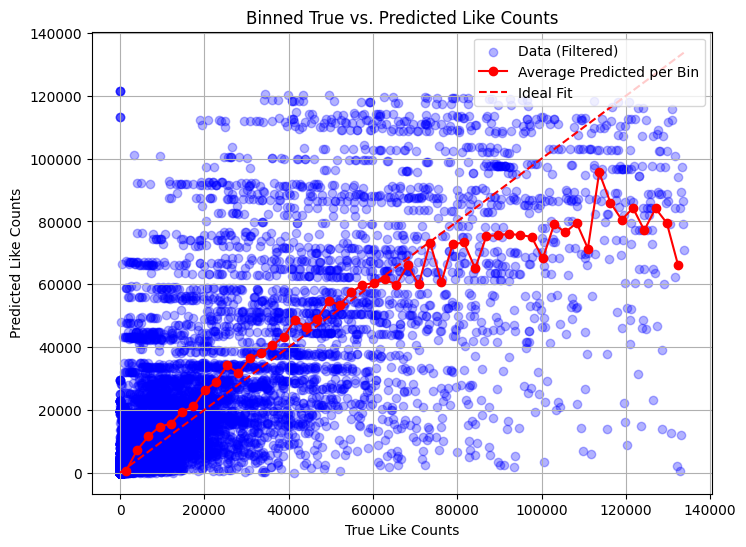

In [66]:
true_vals = np.array(y_like_count_train_true)
pred_vals = np.array(y_like_count_train_pred)

p = 99
true_threshold = np.percentile(true_vals, p)
pred_threshold = np.percentile(pred_vals, p)

mask = (true_vals <= true_threshold) & (pred_vals <= pred_threshold)
filtered_true = true_vals[mask]
filtered_pred = pred_vals[mask]

num_bins = 50
bins = np.linspace(filtered_true.min(), filtered_true.max(), num_bins + 1)

bin_centers = []
avg_preds = []

for i in range(num_bins):
    bin_mask = (filtered_true >= bins[i]) & (filtered_true < bins[i+1])
    bin_values_true = filtered_true[bin_mask]
    bin_values_pred = filtered_pred[bin_mask]

    if len(bin_values_true) > 0:

        center = 0.5 * (bins[i] + bins[i+1])
        bin_centers.append(center)

        avg_preds.append(bin_values_pred.mean())

plt.figure(figsize=(8,6))
plt.scatter(filtered_true, filtered_pred, alpha=0.3, color='blue', label="Data (Filtered)")
plt.plot(bin_centers, avg_preds, 'ro-', label="Average Predicted per Bin")

min_val, max_val = filtered_true.min(), filtered_true.max()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit")

plt.title("Binned True vs. Predicted Like Counts")
plt.xlabel("True Like Counts")
plt.ylabel("Predicted Like Counts")
plt.grid(True)
plt.legend()
plt.show()


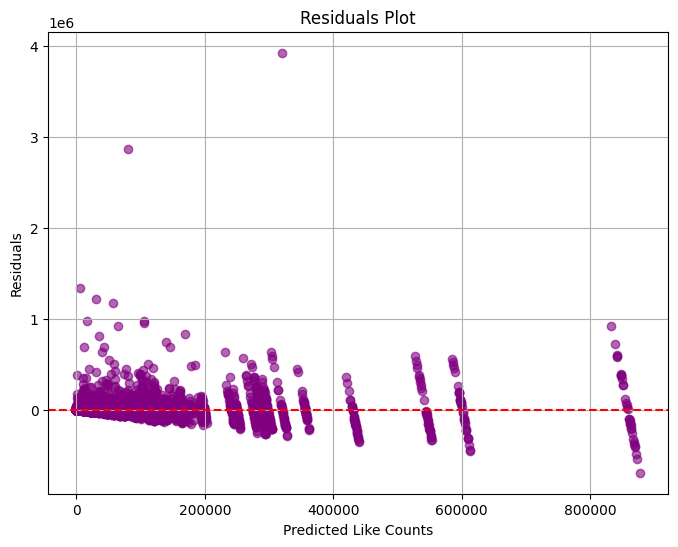

In [76]:
#Residual Plot

residuals = np.array(y_like_count_train_true) - np.array(y_like_count_train_pred)

plt.figure(figsize=(8, 6))
plt.scatter(y_like_count_train_pred, residuals, alpha=0.6, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Predicted Like Counts")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

In [54]:
#@title Predict Test Data (Regression)

test_data_path = "/content/drive/MyDrive/CS412_Project_Round3/released_dataset/test-regression-round3.jsonl"

with open(test_data_path, "rt") as fh:
    for line in fh:
        sample = json.loads(line)
        print(json.dumps(sample, indent=2))
        break


{
  "caption": "Ayval\u0131k Belediyesi Kas\u0131m Ay\u0131 Ola\u011fan Meclis Toplant\u0131s\u0131\u2019n\u0131 Vural Sinemas\u0131 Nejat Uygur Sahnesi\u2019nde ger\u00e7ekle\u015ftirdik.\n\nAl\u0131nan kararlar\u0131n Ayval\u0131k\u2019\u0131m\u0131za hay\u0131rl\u0131 olmas\u0131n\u0131 dilerim.",
  "comments_count": 10,
  "id": "18299464882193238",
  "media_type": "CAROUSEL_ALBUM",
  "media_url": "https://scontent-sof1-2.cdninstagram.com/v/t51.29350-15/398502640_367498438952512_6710374471736346193_n.jpg?_nc_cat=107&ccb=1-7&_nc_sid=c4dd86&_nc_ohc=QFdBTP4J-X8AX8jZhY4&_nc_ht=scontent-sof1-2.cdninstagram.com&edm=AL-3X8kEAAAA&oh=00_AfDe8viPR0XWIPWwP_ravKlJ1b7kqr_pxMs0DT7IIf6DIQ&oe=65585C5E",
  "timestamp": "2023-11-01 12:43:50",
  "username": "mesuterginofficial"
}


In [55]:
#@title Save Outputs

output_path = "/content/prediction-regression-round3.json"

output_dict = {}

with open(test_data_path, "rt") as fh:
    for line in fh:
        sample = json.loads(line)
        post_id = sample.get("id")
        if not post_id:
            continue
        pred_val = predict_like_count(sample["username"], sample)
        output_dict[post_id] = int(pred_val)
with open(output_path, "wt") as of:
    json.dump(output_dict, of, indent="\t")
print("Predictions saved.")

Predictions saved.


In [56]:
output_items = list(output_dict.items())
pprint(output_items[:3])

[('18299464882193238', 1054),
 ('17870639199008459', 197),
 ('17976060503438195', 7059)]
